In [1]:
import h5py
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

ras = [2500]
splits = ["val", "test", "train"]
# PATH = "/vol/cfd/rbc/3D"
PATH = "../data/3D"


def check(check):
    for split in splits:
        for ra in ras:
            path = f"{PATH}/{split}/ra{ra}.h5"
            with h5py.File(path, "r") as file:
                check(file, path)

# Dataset Info

In [ ]:
def dataset_info(file, path):
    print(f"file {path} has {file.attrs['episodes']} episodes")


check(dataset_info)

# Validate Temperature

In [ ]:
def validate(file, path):
    passed = True
    episodes = file.attrs["episodes"]
    steps = file.attrs["steps"]

    with tqdm(total=episodes, desc="Validating..") as pbar:
        for episode in range(episodes):
            states = file[f"states{episode}"]

            # 1) check number of steps
            if len(states) != steps:
                pbar.write(
                    f"Mismatch in number of steps for episode {episode}: expected {steps}, got {len(states)}"
                )

            for step in range(steps):
                # 2) check shape
                if states[step].shape != (6, 32, 48, 48):
                    pbar.write(
                        f"Unexpected shape at episode {episode}, step {step}: {states[step].shape}"
                    )
                    passed = False

                # 3) check temperature range
                min, max = states[step][0].min(), states[step][0].max()
                if min < 0 or max > 1:
                    pbar.write(
                        f"in file {path} at episode {episode} and step {step} - Temperature: min={min}, max={max}"
                    )
                    passed = False
            pbar.update(1)

        # Final result
        if not passed:
            print(f"File {path} failed validation.")
        else:
            print(
                f"File {path} passed validation with {episodes} episodes and {steps} steps each."
            )


check(validate)

# Mean, Min and Max per channel

In [ ]:
def mmms(file, path):
    episodes = file.attrs["episodes"]

    channels = ["T", "u", "v", "w", "p_hy", "p_nhy"]
    means, mins, maxs, stds = {}, {}, {}, {}
    for name in channels:
        means[name] = []
        mins[name] = []
        maxs[name] = []
        stds[name] = []

    for episode in tqdm(range(episodes)):
        # print mean, min, max per channel
        states = np.array(file[f"states{episode}"])

        for ch, name in enumerate(channels):
            means[name].append(states[:, ch, :, :].mean())
            mins[name].append(states[:, ch, :, :].min())
            maxs[name].append(states[:, ch, :, :].max())
            stds[name].append(states[:, ch, :, :].std())

    means = {k: np.mean(v) for k, v in means.items()}
    mins = {k: np.min(v) for k, v in mins.items()}
    maxs = {k: np.max(v) for k, v in maxs.items()}
    stds = {k: np.mean(v) for k, v in stds.items()}
    return means, mins, maxs, stds


for split in splits:
    print(f"Calculating mean, min, max for split {split}")
    channels = ["T", "u", "v", "w", "p_hy", "p_nhy"]
    means, mins, maxs, stds = {}, {}, {}, {}
    for name in channels:
        means[name] = []
        mins[name] = []
        maxs[name] = []
        stds[name] = []

    for ra in ras:
        path = f"{PATH}/{split}/ra{ra}.h5"
        with h5py.File(path, "r") as file:
            mean, min, max, std = mmms(file, path)
            for name in channels:
                means[name].append(mean[name])
                mins[name].append(min[name])
                maxs[name].append(max[name])
                stds[name].append(std[name])

    print(f"Means for {split} split: {means}")
    print(f"Mins for {split} split: {mins}")
    print(f"Maxs for {split} split: {maxs}")
    print(f"Stds for {split} split: {stds}")

    # plot means, mins, maxs
    fig, axs = plt.subplots(1, 6, figsize=(15, 2))
    fig.suptitle(f"Means, Mins, Maxs for {split} split")
    for i, name in enumerate(channels):
        axs[i].plot(ras, means[name], label="Mean", marker="o")
        axs[i].fill_between(
            ras, mins[name], maxs[name], alpha=0.2, label="Min-Max Range"
        )
        axs[i].set_title(name)
        axs[i].set_xlabel("RA")
        axs[i].set_ylabel(name)
        axs[i].set_xscale("log")
    plt.tight_layout()
    plt.show()

# Nusselt Number

In [ ]:
def nu(file, path):
    episodes = file.attrs["episodes"]
    dt = file.attrs["dt"] * 4
    steps = file.attrs["steps"]
    time = np.arange(0, int(steps * dt), dt)

    nus = []
    for episode in range(episodes):
        # print mean, min, max per channel
        nus.append(np.array(file[f"nusselts{episode}"]))
    nus = np.array(nus)
    mean_nu = nus.mean(axis=0)
    std_nu = nus.std(axis=0)

    # plot musselt to step
    plt.figure(figsize=(10, 5))
    plt.plot(time, mean_nu, label="Mean Nusselt Number")
    plt.fill_between(
        time, mean_nu - std_nu, mean_nu + std_nu, alpha=0.2, label="Std Dev Range"
    )
    plt.legend()
    plt.title(f"Nusselt Number for {path}")
    plt.xlabel("Step")
    plt.ylabel("Nusselt Number")
    plt.show()


for split in splits:
    for ra in ras:
        path = f"{PATH}/{split}/ra{ra}.h5"
        with h5py.File(path, "r") as file:
            nu(file, path)

# Physical Quantities

In [2]:
import torch
from torch.nn.functional import mse_loss


def compute_div(state):
    # state in [C, D, H, W]
    u = state[1]
    v = state[2]
    w = state[3]

    # grid spacings
    Lx, Ly, Lz = (2 * np.pi, 2 * np.pi, 2.0)
    ny, nz, nx = u.shape
    dx = Lx / nx
    dy = Ly / ny
    dz = Lz / nz

    # centered finite differences everywhere
    dudx = torch.gradient(u, dim=2, spacing=dx)[0]
    dvdy = torch.gradient(v, dim=0, spacing=dy)[0]
    dwdz = torch.gradient(w, dim=1, spacing=dz)[0]
    div = dudx + dvdy + dwdz

    return div, dudx, dvdy, dwdz

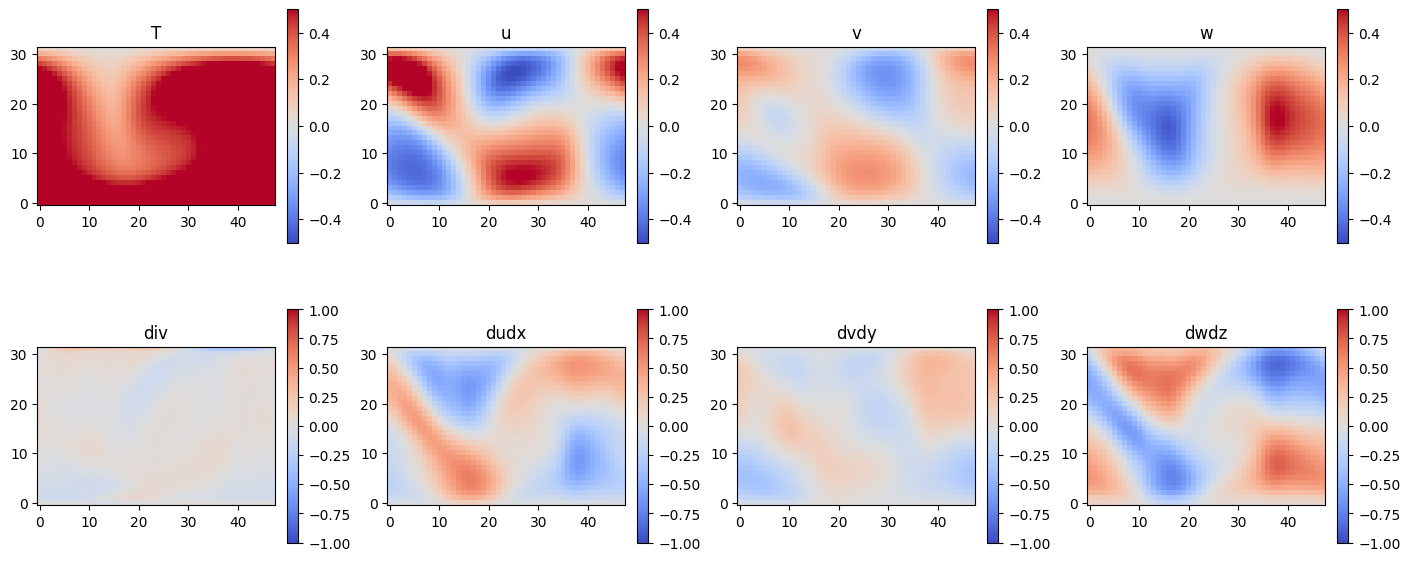

In [3]:
path = f"{PATH}/train/ra2500.h5"
with h5py.File(path, "r") as file:
    steps = file.attrs["steps"]
    state = file["states3"][200]
    state = torch.from_numpy(state).permute((0, 2, 1, 3))

T = state[0]
u = state[1]
v = state[2]
w = state[3]

div, dudx, dvdy, dwdz = compute_div(state)

# visualize fields and derivatives
slice_idx = 24
top_fields = [("T", T), ("u", u), ("v", v), ("w", w)]
bottom_fields = [("div", div), ("dudx", dudx), ("dvdy", dvdy), ("dwdz", dwdz)]

fig, axes = plt.subplots(2, 4, figsize=(14, 6), constrained_layout=True)
for col, (name, field) in enumerate(top_fields):
    ax = axes[0, col]
    img = ax.imshow(
        field[slice_idx].cpu().detach().numpy(),
        cmap="coolwarm",
        origin="lower",
        vmin=-0.5,
        vmax=0.5,
    )
    ax.set_title(name)
    fig.colorbar(img, ax=ax, shrink=0.8)

for col, (name, field) in enumerate(bottom_fields):
    ax = axes[1, col]
    if field is None:
        ax.axis("off")
        continue
    img = ax.imshow(
        field[slice_idx].cpu().detach().numpy(),
        cmap="coolwarm",
        origin="lower",
        vmin=-1,
        vmax=1,
    )
    ax.set_title(name)
    fig.colorbar(img, ax=ax, shrink=0.8)

plt.show()

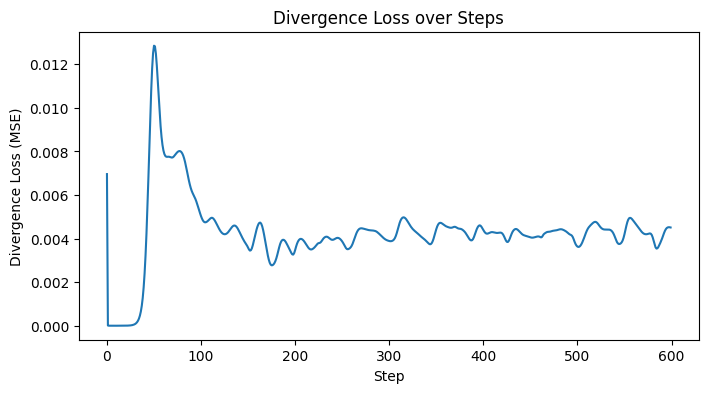

In [ ]:
path = f"{PATH}/train/ra2500.h5"

with h5py.File(path, "r") as file:
    steps = file.attrs["steps"]
    episodes = file.attrs["episodes"]

    states = file["states5"]
    list = []
    for step in range(steps):
        state = torch.from_numpy(states[step]).permute((0, 2, 1, 3))
        div, _, _, _ = compute_div(state)
        list.append(mse_loss(div, torch.zeros_like(div)))

    # plot loss over steps
    plt.figure(figsize=(8, 4))
    plt.plot(range(steps), list)
    plt.xlabel("Step")
    plt.ylabel("Divergence Loss (MSE)")
    plt.title("Divergence Loss over Steps")
    plt.show()